# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [55]:
%tensorflow_version 2.x

In [2]:
! wget -O resources.zip https://ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com/cd/0/inline/BIaRLFjy59--thi6E4swPxzV5fuh-_XpP5dyz0UFPSGy3uyj69Lj5XNKQl-6qeuSq-incriwY47uEfJEZjZI6gIP7fRHkC3sUyHAYDaLwSzmIQ/file
!unzip resources.zip

--2021-02-06 18:09:34--  https://ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com/cd/0/inline/BIaRLFjy59--thi6E4swPxzV5fuh-_XpP5dyz0UFPSGy3uyj69Lj5XNKQl-6qeuSq-incriwY47uEfJEZjZI6gIP7fRHkC3sUyHAYDaLwSzmIQ/file
Resolving ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com (ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:6019:15::a27d:40f
Connecting to ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com (ucb3aeb654e60f3648f04f22eb59.dl.dropboxusercontent.com)|162.125.6.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /cd/0/inline2/BIckZB4S76LWIZ4y52ax7dhUnxjKzSb2HQXiibE_dyB9D_uFvJiYATat2b739O1R6G2V-4vCZWktrENpgU06YboSXKTfoT5P8fMQIzGYBFgKsNq0pdcYUj5Kq3bVSvPviYJ2ySknx7vjYgE44ySxKx9EnskR9oRrY-_DrPeNQIohdkRI59niz3i9qRN3m92B2UO-YWwRVrSikrnxWw9JmEGVZueoi3jobl0u0net5H5A6toJgweOnge9ueUjApQuXEp3GA1b_Y7bOV7TvVGK_o547GHRXmXryDHMBvpjBMEYPJVwD14O8-g3gGTB_5D2DLx3pUjJ-B4BWjBuQlzrRilc/file [following]
--2021-02-06 18:09:34-- 

In [3]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

In [4]:
%tensorflow_version 2.x

In [5]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [6]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [7]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [8]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [9]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [10]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [11]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 269 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
y_test = [sent2labels(sent) for sent in test_data]
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)

In [12]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [13]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [14]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [15]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)

## 4. Train a model

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [17]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=10,verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 102, 32)           480608    
_________________________________________________________________
bidirectional (Bidirectional (None, 102, 64)           12672     
_________________________________________________________________
dropout (Dropout)            (None, 102, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 18s 19ms/step - loss: 0.3935 - categorical_accuracy: 0.3655
Epoch 2

In [18]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 5s 18ms/step - loss: 0.0175 - categorical_accuracy: 0.9626
Epoch 2/10
290/290 [==============================] - 5s 18ms/step - loss: 0.0168 - categorical_accuracy: 0.9641
Epoch 3/10
290/290 [==============================] - 5s 19ms/step - loss: 0.0163 - categorical_accuracy: 0.9648
Epoch 4/10
290/290 [==============================] - 5s 19ms/step - loss: 0.0157 - categorical_accuracy: 0.9662
Epoch 5/10
290/290 [==============================] - 5s 19ms/step - loss: 0.0152 - categorical_accuracy: 0.9671
Epoch 6/10
290/290 [==============================] - 5s 18ms/step - loss: 0.0148 - categorical_accuracy: 0.9682
Epoch 7/10
290/290 [==============================] - 5s 19ms/step - loss: 0.0143 - categorical_accuracy: 0.9693
Epoch 8/10
290/290 [==============================] - 5s 19ms/step - loss: 0.0139 - categorical_accuracy: 0.9697
Epoch 9/10
290/290 [==============================] - 5s 18ms/step - loss: 0.0134 - categorical_

In [19]:
%%time
#model.save_weights('/data/my_pos_no_crf.h5')
#model.load_weights('/data/my_pos_no_crf.h5')
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8638,99.4573,99.6601,3665
1,2,94.4808,94.6411,94.5609,7806
2,3,89.7288,96.5717,93.0246,16310
3,4,99.9455,99.3886,99.6663,12843
4,5,95.6522,98.5075,97.0588,66
5,6,98.954,90.613,94.6,473
6,7,98.2091,97.595,97.9011,2029
7,8,70.3822,53.253,60.631,221
8,9,70.7165,61.6848,65.8926,227
9,10,61.9643,41.3588,49.6069,347


CPU times: user 2.98 s, sys: 91.1 ms, total: 3.07 s
Wall time: 2.82 s


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [20]:
x_train.shape

(18500, 102)

In [21]:
y_train.shape

(18500, 102, 48)

In [24]:
import numpy
from tf2crf import CRF, ModelWithCRFLoss


inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes)(output)
crf = CRF(dtype='float32')
output = crf(output)
model = Model(inputs, output)
model = ModelWithCRFLoss(model)
model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])

# model.summary()
model.fit(x_train,y=np.argmax(y_train, axis=2), batch_size=64,epochs=13,verbose=1)

model.save_weights('to_do1.h5')


Epoch 1/13
290/290 [==============================] - 69s 212ms/step - crf_loss: 26.1031 - accuracy: 0.5658
Epoch 2/13
290/290 [==============================] - 62s 212ms/step - crf_loss: 5.8303 - accuracy: 0.9078
Epoch 3/13
290/290 [==============================] - 62s 213ms/step - crf_loss: 3.6437 - accuracy: 0.9361
Epoch 4/13
290/290 [==============================] - 62s 215ms/step - crf_loss: 2.9005 - accuracy: 0.9461
Epoch 5/13
290/290 [==============================] - 62s 212ms/step - crf_loss: 2.5621 - accuracy: 0.9509
Epoch 6/13
290/290 [==============================] - 61s 209ms/step - crf_loss: 2.3431 - accuracy: 0.9539
Epoch 7/13
290/290 [==============================] - 60s 207ms/step - crf_loss: 2.1868 - accuracy: 0.9562
Epoch 8/13
290/290 [==============================] - 60s 207ms/step - crf_loss: 2.0427 - accuracy: 0.9583
Epoch 9/13
290/290 [==============================] - 60s 208ms/step - crf_loss: 1.9442 - accuracy: 0.9600
Epoch 10/13
290/290 [===============

In [27]:
#model.load_weights('/data/my_pos_no_crf.h5')
y_pred=model.predict(x_test)

evaluation_report(y_test, y_pred[0])

,tag,precision,recall,f_score,correct_count
0,0,-,0,-,0
1,1,99.7827,99.7015,99.7421,3674
2,2,95.1404,94.4714,94.8047,7792
3,3,91.1425,96.2638,93.6332,16258
4,4,99.9922,99.644,99.8178,12876
5,5,88,98.5075,92.9577,66
6,6,99.7817,87.5479,93.2653,457
7,7,97.5551,97.8836,97.7191,2035
8,8,69.2833,48.9157,57.3446,203
9,9,61.0667,62.2283,61.642,229



### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [29]:
import embeddings.emb_reader as emb

In [38]:
pretrained_dict =  emb.get_embeddings()

In [42]:
embedding_matrix = []
count = 0
for key in word_to_idx:
  if key in pretrained_dict:
    embedding_matrix.append(pretrained_dict[key])
  else:
    count += 1
    embedding_matrix.append(np.zeros(64))
print(count)

11313


In [43]:
np.array(embedding_matrix).shape

(15019, 64)

In [46]:
import numpy
from tf2crf import CRF, ModelWithCRFLoss
from keras import initializers

inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),64,input_length=102,mask_zero=True,embeddings_initializer=initializers.Constant(embedding_matrix)))(inputs)
output = Bidirectional(GRU(64, return_sequences=True))(output)
output = Dropout(0.2)(output)
crf = CRF(dtype='float32')
output = crf(output)
model = Model(inputs, output)
model = ModelWithCRFLoss(model)
model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])

model.fit(x_train,y=np.argmax(y_train, axis=2), batch_size=1024,epochs=13,verbose=1)
model.summary()

Epoch 1/13
290/290 [==============================] - 73s 227ms/step - crf_loss: 51.6465 - accuracy: 0.2233
Epoch 2/13
290/290 [==============================] - 65s 226ms/step - crf_loss: 38.7382 - accuracy: 0.3560
Epoch 3/13
290/290 [==============================] - 65s 225ms/step - crf_loss: 31.3212 - accuracy: 0.4590
Epoch 4/13
290/290 [==============================] - 66s 226ms/step - crf_loss: 26.1557 - accuracy: 0.5974
Epoch 5/13
290/290 [==============================] - 66s 227ms/step - crf_loss: 22.5115 - accuracy: 0.6728
Epoch 6/13
290/290 [==============================] - 66s 226ms/step - crf_loss: 18.7231 - accuracy: 0.8211
Epoch 7/13
290/290 [==============================] - 66s 227ms/step - crf_loss: 16.4863 - accuracy: 0.8426
Epoch 8/13
290/290 [==============================] - 65s 225ms/step - crf_loss: 15.2270 - accuracy: 0.8428
Epoch 9/13
290/290 [==============================] - 65s 225ms/step - crf_loss: 14.5125 - accuracy: 0.8352
Epoch 10/13
290/290 [=======

In [54]:
y_pred=model.predict(x_test)

evaluation_report(y_test, y_pred[0])

,tag,precision,recall,f_score,correct_count
0,0,-,0,-,0
1,1,84.8258,98.4532,91.1329,3628
2,2,91.0856,91.5495,91.317,7551
3,3,80.7324,97.2526,88.2258,16425
4,4,92.6866,98.8624,95.675,12775
5,5,-,0,-,0
6,6,99.7696,82.9502,90.5858,433
7,7,96.7376,65.6085,78.1886,1364
8,8,78.2946,24.3373,37.1324,101
9,9,62.2642,8.96739,15.677,33


In [51]:
import keras.backend as K
K.clear_session()

In [47]:
model.save_weights('to_do2.h5')

### #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

  from evalution results, 4.2.x perform better bacause CRF have a transition matrix that will put probablitity aporches to model and that will make language more sensible in the way of its principle

### #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here : From the  2 heat maps above (first one is crf matrix after training, second one is crf matrix before training) the Before training show that value are random but after training the heatmap change, only some of transition has high freqency while the others has less frequency. It was sensible because if we look by the view of language's principle it always has corelation about some POS with other POS but not every POS that support the assumption in first plot.</b>

In [80]:
import numpy
from tf2crf import CRF, ModelWithCRFLoss


inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes)(output)
crf = CRF(dtype='float32')
output = crf(output)
model = Model(inputs, output)
model = ModelWithCRFLoss(model)
model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])
model.built = True 
model.load_weights('to_do1.h5')

In [ ]:
import numpy
from tf2crf import CRF, ModelWithCRFLoss


inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes)(output)
crf_zero = CRF(dtype='float32')
output = crf_zero(output)
model2 = Model(inputs, output)
model2 = ModelWithCRFLoss(model2)
model2.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])
model.built = True 

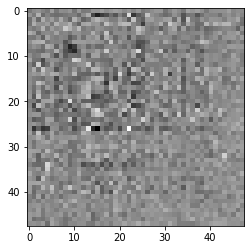

In [121]:
## after train

import numpy as np 
import matplotlib.pyplot as plt

H = crf.transitions 
plt.imshow(H, cmap='gray')
plt.show()

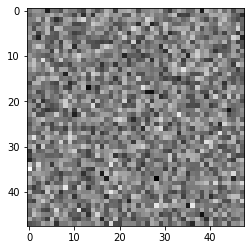

In [120]:
## before train

import numpy as np 
import matplotlib.pyplot as plt

H = crf_zero.transitions 
plt.imshow(H, cmap = 'gray')
plt.show()